In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import time

In [3]:
print('torch.cuda.is_available:\t',torch.cuda.is_available())
print('torch.cuda.device_count:\t',torch.cuda.device_count())
print('torch.cuda.current_device:\t',torch.cuda.current_device())
print('torch.cuda.device:\t\t',torch.cuda.device(0))
print('torch.cuda.get_device_name:\t',torch.cuda.get_device_name(0))
print()

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    else:
        print('Running on {}'.format(device))
    return device

device = set_device("gpu")

torch.cuda.is_available:	 True
torch.cuda.device_count:	 1
torch.cuda.current_device:	 0
torch.cuda.device:		 <torch.cuda.device object at 0x7fe01c1a44f0>
torch.cuda.get_device_name:	 Quadro RTX 4000

Cuda installed! Running on GPU 0 Quadro RTX 4000!


In [4]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x0, tolerance=1e-6, max_iterations=10000):
    """
    Solves a linear system of equations using the Gauss-Seidel method.
    
    Parameters
    ----------
    A (numpy.ndarray): Coefficient matrix.
    b (numpy.ndarray): Right-hand side vector.
    x0 (numpy.ndarray): Initial guess for the solution vector.
    tol (float): Tolerance for convergence.
    max_iter (int): Maximum number of iterations.
    
    Returns
    ----------
    x (numpy.ndarray): Solution vector.
    """
    x = x0.clone().detach()
    x_old = x0.clone().detach()
    for k in range(max_iterations):
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - torch.matmul(A[i,:i], x[:i]) - torch.matmul(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        error = torch.max(torch.abs(x - x_old))
        if  error < tolerance:
            print(f'The L infinity norm in iteration {k+1} is: {error}') 
            break     
        x_old[:] = x 
    else:
        print(f'***WARNING*** Max number of iteration reached {k+1}, L infinity norm is: {error}')        
    return x

def jacobi(A, b, x0, tolerance=1e-6, max_iterations=50000):
    """
    Solves a linear system of equations using the Jacobi method.
    
    Parameters:
    A (numpy.ndarray): Coefficient matrix.
    b (numpy.ndarray): Right-hand side vector.
    x0 (numpy.ndarray): Initial guess for the solution vector.
    tolerance (float): Tolerance for convergence.
    max_iterations (int): Maximum number of iterations.
    
    Returns:
    x (numpy.ndarray): Solution vector.
    """    
    x_old = x0.clone().detach()
    x = torch.empty_like(x0)
    diagonal = A.diag()
    B = A - torch.diag(diagonal)     
    for k in range(max_iterations): 
        x[:] = (b - torch.matmul(B, x_old)) / diagonal   
        #Stop condition 
        error = torch.max(torch.abs(x - x_old))
        if  error < tolerance:   
            print(f'The L infinity norm in iteration {k+1} is: {error}') 
            break      
        x_old[:] = x
    else:
        print(f'***WARNING*** Max number of iteration reached {k+1}, L infinity norm is: {error}')        
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        return torch.linalg.solve(A, b)
        #return jacobi(A, b, -b)
        #return gauss_seidel(A, b, -b)
        #return torch.linalg.pinv(A).matmul(b) 

### Poisson Equation

$
\nabla^2 u = \mathbf{f} 
$



In [5]:
# (solve Au=f) Obs.: The matrix A for poisson with pure Neumann boundary conditions is singular. To solve make "sum f = 0".
# For this case (pure Neumann) there are infinite solution (different constants). 

class Poisson(nn.Module): 
    """
    Finite difference solution of the Poisson equation (elliptic equation)

    Parameters
    ----------
    dx: float
        Block size in meters
    N: int
        Number of blocks
    source_term: list (or numpy array) of floats
        Source term (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet' or 'Neumann'), e.g. ['Dirichlet','Neumann']    
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    
    Methods
    -------
    forward()
        Solve the Possion equation (Au=f)

    """    
    def __init__(self, dx, N, source_term, boundary_type = ['Dirichlet','Dirichlet'], boundary_values = [0., 0.]):     
        super().__init__()
        self.N = N # torch.tensor(N, dtype=torch.int32, device=device) -> give error compiled version  
        self.dx = torch.tensor(dx, dtype=torch.float32, device=device)    
        self.source_term = torch.tensor(source_term, dtype=torch.float32, device=device)
        self.calculated_A_f = False
        self.boundary_type = boundary_type
        self.boundary_values = torch.tensor(boundary_values, dtype=torch.float32, device=device)
        self.applied_boundary = False
        self.A = None
        self.f = None
        
    def calc_A_f_no_boundary(self):
        if not self.calculated_A_f:
            d = 1/(self.dx*self.dx)
            a_main = -2*d*torch.ones((self.N,), dtype=torch.float32, device=device)
            a_upper = d*torch.ones((self.N-1,), dtype=torch.float32, device=device)
            a_lower = d*torch.ones((self.N-1,), dtype=torch.float32, device=device)
            self.A  = torch.diag(a_main, 0)   # Main diagonal
            self.A += torch.diag(a_upper, 1)  # Upper diagonal
            self.A += torch.diag(a_lower,-1)  # Lower diagonal    
            self.f = self.source_term.to(device)                                                                 # Source term
            self.calculated_A_f = True
        return self.A, self.f
    
    def apply_boundary_condition(self):
        #assert self.calculated_A_f, 'Matriz A or f not calculeted yet!'
        if not self.applied_boundary:
            #Left boundary
            if self.boundary_type[0] == 'Dirichlet':
                self.f[0] += self.boundary_values[0]/(-self.dx*self.dx)   
            elif self.boundary_type[0] == 'Neumann':
                self.f[0]  += self.boundary_values[0]/(self.dx)   
                self.A[0,0] += 1/(self.dx*self.dx)
                #self.f -= self.f.mean()  # For pure Neumann boundary condition to have a solution
            else:
                raise RuntimeError('Left boundary: no condition satisfied!')
            #Right boundary
            if self.boundary_type[1] == 'Dirichlet':
                self.f[-1] += self.boundary_values[-1]/(-self.dx*self.dx) 
            elif self.boundary_type[1] == 'Neumann':
                self.f[-1] += self.boundary_values[-1]/(-self.dx)  
                self.A[-1,-1] += 1/(self.dx*self.dx)
                #self.f -= self.f.mean()  # For pure Neumann boundary condition to have a solution
            else:
                raise RuntimeError('Right boundary: no condition satisfied!')
            self.applied_boundary = True
        return self.A, self.f       
   

    def forward(self):
        """
        Solve the Poisson equation (Au=f)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field (one value per block -> size N)

        """  
        self.calc_A_f_no_boundary()
        self.apply_boundary_condition()   
        return solve_linear(self.A, self.f)
        
        

In [6]:
poisson = Poisson(dx=0.01,
                  N=1000,
                  source_term=np.sin(np.linspace(np.pi,2*np.pi,1000,endpoint=False))**5, #40*[0.]+30*[-10.]+40*[0.],
                  #boundary_type = ['Dirichlet','Neumann'], 
                  boundary_type = ['Dirichlet','Dirichlet'], 
                  #boundary_type = ['Neumann','Neumann'], 
                  boundary_values = [0, 0]).to(device)
compiled_poisson = torch.compile(poisson) #fullgraph=True #mode="max-autotune" #mode="reduce-overhead")

[2023-05-11 14:35:36,141] torch._inductor.graph: [WARNING] error in realize_users_of
Traceback (most recent call last):
  File "/home/viluiz/anaconda3/envs/numpde/lib/python3.10/site-packages/torch/_inductor/graph.py", line 231, in realize_users_of
    visit(value)
  File "/home/viluiz/anaconda3/envs/numpde/lib/python3.10/site-packages/torch/_inductor/graph.py", line 225, in visit
    if value.is_user_of(name):
  File "/home/viluiz/anaconda3/envs/numpde/lib/python3.10/site-packages/torch/_inductor/ir.py", line 347, in is_user_of
    return any(name == dep.name for dep in self.get_reads())
  File "/home/viluiz/anaconda3/envs/numpde/lib/python3.10/site-packages/torch/_inductor/ir.py", line 3860, in __getattr__
    fn = getattr(self.data, name)
  File "/home/viluiz/anaconda3/envs/numpde/lib/python3.10/site-packages/torch/_inductor/ir.py", line 3860, in __getattr__
    fn = getattr(self.data, name)
AttributeError: 'NoneType' object has no attribute 'get_reads'


Runtime: 2.5980963706970215


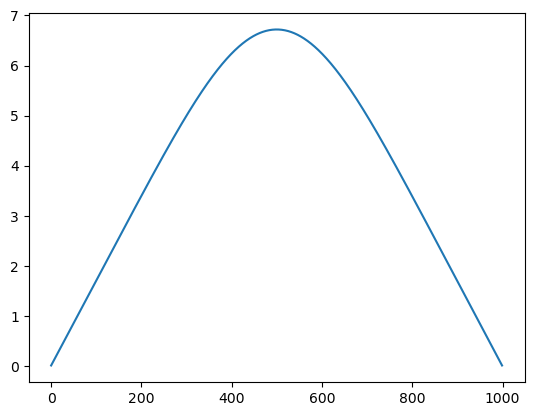

In [7]:
start = time.time()
with torch.no_grad(): 
    u = compiled_poisson()
print('Runtime:',time.time()-start)
plt.plot(u.cpu())

Runtime: 0.034111976623535156


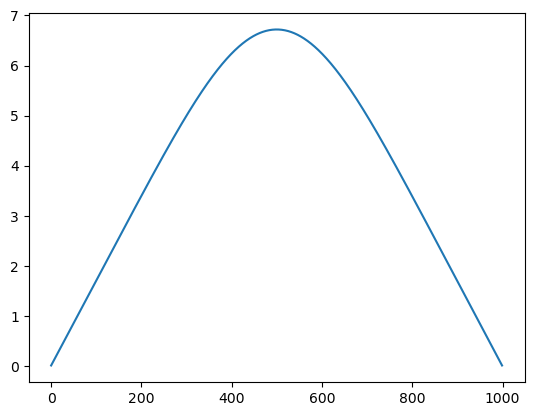

In [8]:
start = time.time()
with torch.no_grad(): 
    u = compiled_poisson()
print('Runtime:',time.time()-start)
plt.plot(u.cpu())

Runtime: 0.08555459976196289


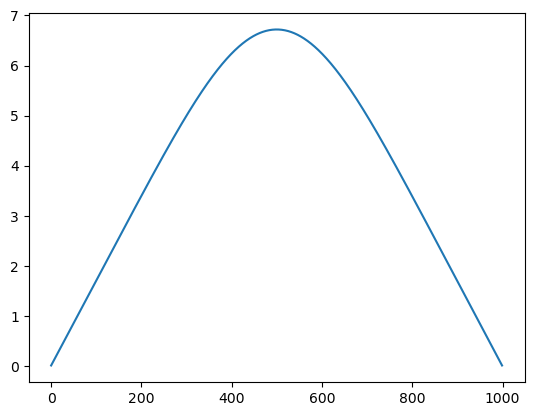

In [9]:
start = time.time()
for _ in range(10):
    with torch.no_grad(): 
        u = compiled_poisson()
print('Runtime:',time.time()-start)
plt.plot(u.cpu())

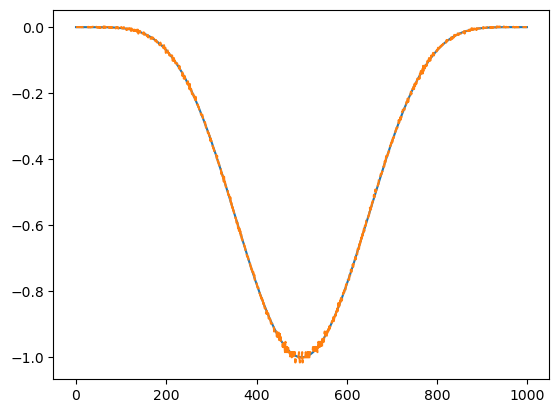

In [10]:
plt.plot(poisson.f.cpu())
plt.plot(poisson.A.matmul(u).cpu(),'--')

In [11]:
torch.max(torch.abs(poisson.A.matmul(u)-poisson.f))

tensor(0.0205, device='cuda:0')

In [12]:
torch.linalg.det(poisson.A)

tensor(inf, device='cuda:0')

In [13]:
print(poisson.f)

tensor([ 0.0000e+00, -3.0602e-13, -9.7923e-12, -7.4357e-11, -3.1332e-10,
        -9.5611e-10, -2.3789e-09, -5.1412e-09, -1.0022e-08, -1.8058e-08,
        -3.0577e-08, -4.9236e-08, -7.6057e-08, -1.1347e-07, -1.6432e-07,
        -2.3195e-07, -3.2021e-07, -4.3347e-07, -5.7671e-07, -7.5549e-07,
        -9.7605e-07, -1.2453e-06, -1.5708e-06, -1.9611e-06, -2.4252e-06,
        -2.9731e-06, -3.6158e-06, -4.3648e-06, -5.2329e-06, -6.2335e-06,
        -7.3814e-06, -8.6921e-06, -1.0182e-05, -1.1869e-05, -1.3773e-05,
        -1.5912e-05, -1.8308e-05, -2.0983e-05, -2.3961e-05, -2.7267e-05,
        -3.0927e-05, -3.4967e-05, -3.9418e-05, -4.4308e-05, -4.9670e-05,
        -5.5536e-05, -6.1941e-05, -6.8920e-05, -7.6510e-05, -8.4751e-05,
        -9.3683e-05, -1.0335e-04, -1.1379e-04, -1.2505e-04, -1.3718e-04,
        -1.5023e-04, -1.6424e-04, -1.7927e-04, -1.9537e-04, -2.1260e-04,
        -2.3101e-04, -2.5066e-04, -2.7162e-04, -2.9394e-04, -3.1769e-04,
        -3.4293e-04, -3.6973e-04, -3.9817e-04, -4.2

In [14]:
print(poisson.A)

tensor([[-20000.,  10000.,      0.,  ...,      0.,      0.,      0.],
        [ 10000., -20000.,  10000.,  ...,      0.,      0.,      0.],
        [     0.,  10000., -20000.,  ...,      0.,      0.,      0.],
        ...,
        [     0.,      0.,      0.,  ..., -20000.,  10000.,      0.],
        [     0.,      0.,      0.,  ...,  10000., -20000.,  10000.],
        [     0.,      0.,      0.,  ...,      0.,  10000., -20000.]],
       device='cuda:0')
